# ERT inversion - beyond the standard

Here, we exemplify the possibilities of pyGIMLi by treating an ERT timelapse data set. Most of the strategies are independent on the method and can be used for other types of data.

The data set here was published by Hübner et al. (2017) and describes a shallow infiltration experiment using a surface electrode layout.

![Survey layout](slides/images/survey.png)

In [1]:
# We import some basic libraries like numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Furthermore we import pygimli and three of its modules
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt
from pygimli.viewer import pv

No module named 'trame'.
You need to install this optional dependency to use interactive 3D visualizations within Jupyter notebooks.


From the whole timelapse set of data files we load a single one, show its properties.

19/03/24 - 16:26:30 - pyGIMLi - INFO - Looking for ert/Huebner2017/007.dat in gimli-org/example-data/


Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


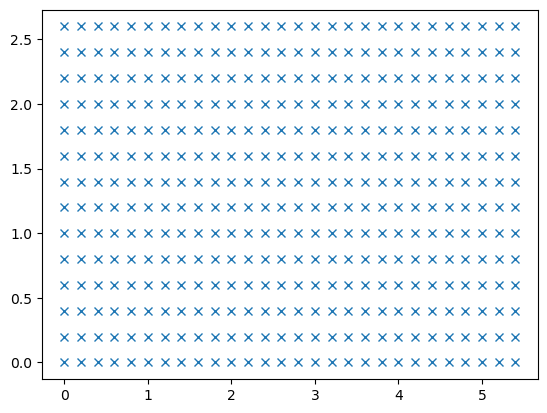

In [5]:
data = pg.getExampleData("ert/Huebner2017/007.dat")
print(data)
plt.plot(pg.x(data), pg.y(data), 'x');

The data contains 2849 measurements using 392 electrodes. In the `DataContainer`, there are AB-MN indices of the electrodes resistances (`'r'`). We first plot the electrode positions (Hübner et al. 2017, Fig. 1).

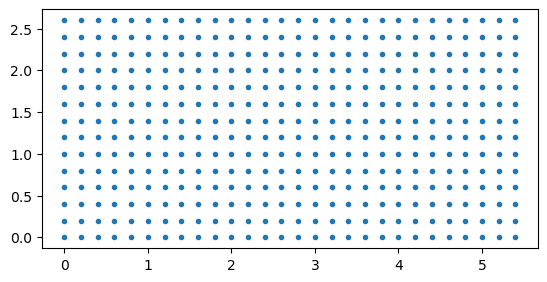

In [6]:
plt.plot(pg.x(data), pg.y(data), ".")
plt.gca().set_aspect(1.0);

We then compute the geometric factors and apparent resistivities and store both in the data container.

In [9]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]
data['err'] = 0.02
print(data)

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']


The data exhibit mostly dipole-dipole data measured with a 12-channel ABEM Terrameter LS2 instrument. To fill up the channels, some multi-gradient and some square arrays have been added. We can have a look at the data by using `data.show()`. The `style` argument generates a crossplot of the A over the M electrode. See [`ert.showERTData`](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.ert.html#pygimli.physics.ert.showERTData).

19/03/24 - 16:31:25 - pyGIMLi - INFO - found 245 x values
19/03/24 - 16:31:25 - pyGIMLi - INFO - found 143 y values
19/03/24 - 16:31:25 - pyGIMLi - INFO - x vector length: 2849
19/03/24 - 16:31:25 - pyGIMLi - INFO - y vector length: 2849
19/03/24 - 16:31:25 - pyGIMLi - INFO - v vector length: 2849
19/03/24 - 16:31:25 - pyGIMLi - INFO - 1390 data of 2849 not shown


Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'xa', 'xb', 'xm', 'xn']

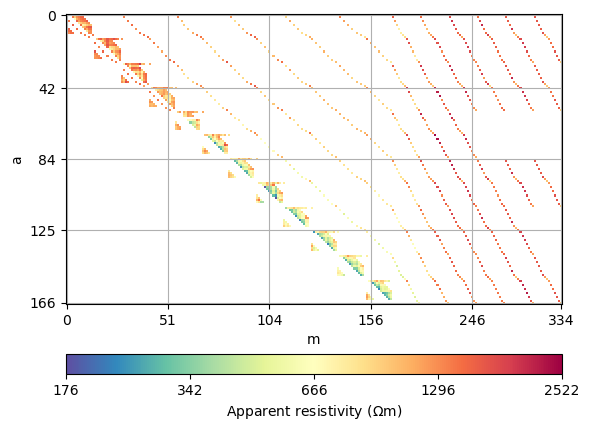

In [10]:
data.show(style="A-M");
data.subset(x=1)
x1 = data.subset(x=1)


We can already see the pseudosections on the main diagonal with some reciprocals mirrored at the diagonal, plus some measurements between the lines (off-diagonals).

## Error estimation
For inversion we need an error estimate to weight the individual data points. The analysis of normal vs. reciprocal data is a common strategy to quantify the data error. We have a very limited amount of reciprocal data pairs with which we can do a reciprocal analysis, i.e. a statistical analysis of the reciprocity deviations as a function of the measured resistance.
For an example with more rigorous data and background of normal-reciprocal analysis see, based on Udphuay et al. (2011), [this example](https://dev.pygimli.org/_examples_auto/3_ert/plot_10_reciprocal_analysis.html). 

We generate an error model by assuming a relative error of 2%.

In [11]:
# data.estimateError(relativeError=0.02)
data["err"] = 0.02

For demonstration purposes, we will first work on 2D profiles. Therefore, we extract a single profile from the data using the `subset` command for a constant line along x=0. For 2D inversion, we exchange the x and the y coordinates.

Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'xa', 'xb', 'xm', 'xn']
Detecting small distances, using mm accuracy


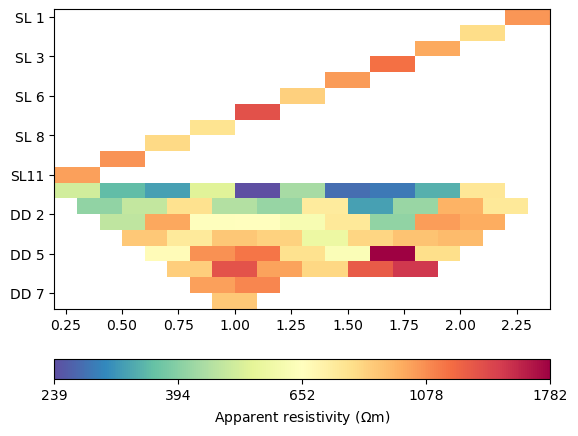

In [15]:
x0 = data.subset(x=1)
print(x0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)*0])) # auto for x/y
ax, cb = x0.show()

The upper part is a single multi-gradient using the outermost electrodes, the lower a dipole-dipole section. If we think one of the values is an outlier, we can remove it by logical operations.

Detecting small distances, using mm accuracy


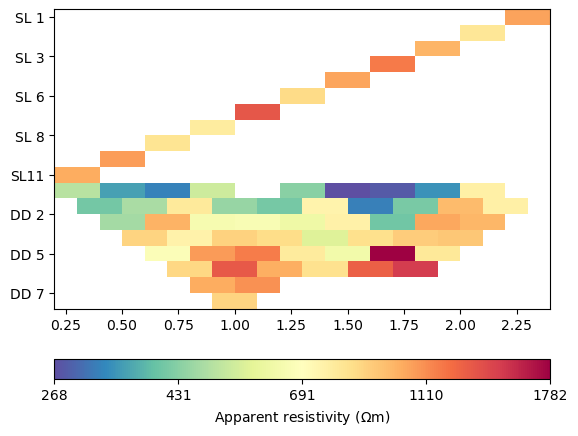

In [16]:
x0.remove(x0["rhoa"] < 250)
ax, cb = x0.show()

In [17]:
mgr = ert.Manager(x0)
mgr.invert(verbose=True)
pg.setLogLevel('WARNING')

19/03/24 - 16:36:13 - pyGIMLi - INFO - Found 2 regions.
19/03/24 - 16:36:13 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
19/03/24 - 16:36:13 - pyGIMLi - INFO - Found 2 regions.
19/03/24 - 16:36:13 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
19/03/24 - 16:36:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/03/24 - 16:36:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/03/24 - 16:36:13 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
19/03/24 - 16:36:13 - pyGIMLi - INFO - Use median(data values)=819.2300000000007
19/03/24 - 16:36:13 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=819.230000/819.230000
19/03/24 - 16:36:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002302BA34D10>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002302BA34B80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002302BA34F40>
min/max (data): 268/1782
min/max (error): 2%/2%
min/max (start model): 819/819
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  467.41
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   76.15 (dPhi = 83.22%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.91 (dPhi = 84.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.92 (dPhi = 31.84%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.92 (dPhi = 0.09%) lam: 20.0
####################

The data seem to be fitted well. First, we want to compare measured and modelled data by `showFit()` and in more detail by `showMisfit()`.

Detecting small distances, using mm accuracy
Detecting small distances, using mm accuracy


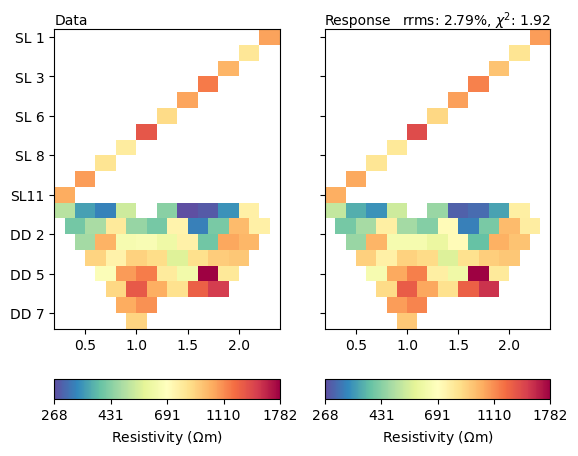

In [18]:
mgr.showFit();

For details on RMS and chi-square values see [this tutorial](https://www.pygimli.org/_tutorials_auto/3_inversion/plot_1-polyfit.html).

For a closer look at the differences, we show the misfit distribution:

Detecting small distances, using mm accuracy


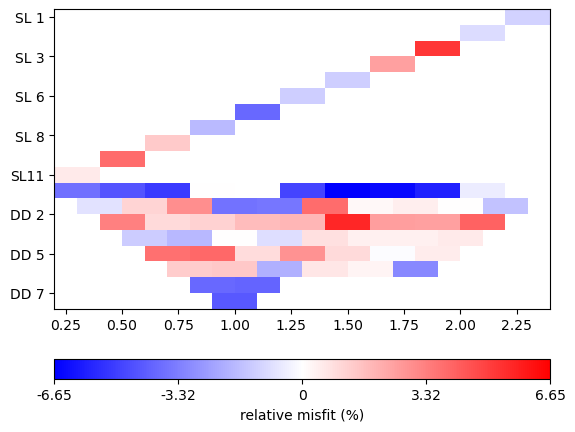

In [19]:
mgr.showMisfit()

There is some limited systematics in the misfit distribution.
Nevertheless, we feel qualified to have a look at the inversion result.

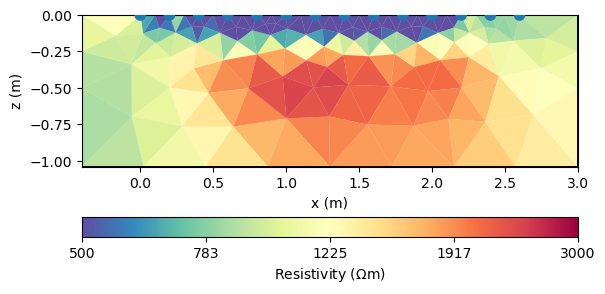

In [20]:
# We show the result using a predefined color-scale
kw = dict(cMin=500, cMax=3000, cMap="Spectral_r", 
          logScale=True, coverage=1,
          xlabel="x (m)", ylabel="z (m)")
ax, cb = mgr.showResult(**kw)
# we can  modify the figure using the axis and colorbar handles

## Regular grids
One can, of course, also work with regular meshes.
Here, we create a regular grid with 10 cm grid spacing.
In order to ensure accurate boundary conditions in the forward modelling, we append a triangle mesh around it.

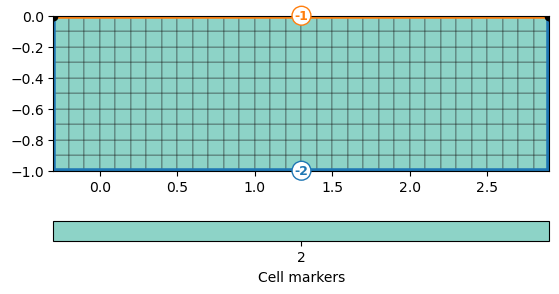

In [21]:
grid = pg.createGrid(x=np.arange(-0.3, 3.0, 0.1),
                     y=np.arange(-1., 0.01, 0.1), 
                     marker=2, 
                     worldBoundaryMarker=True)
ax, cb = pg.show(grid, markers=True, showMesh=True)

The markers 1 (background) and 2 (inversion) define the default behaviour in the inversion.

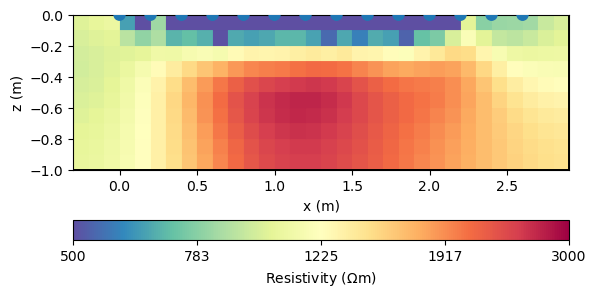

In [22]:
# Try this later!
mgr = ert.Manager(x0)
mgr.setMesh(grid)
mgr.invert()
ax, cb = mgr.showResult(**kw)
# We save the model for later 
x0result = mgr.paraDomain
x0result["res"] = mgr.model

We now choose another profile along the y axis.

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']
Detecting small distances, using mm accuracy


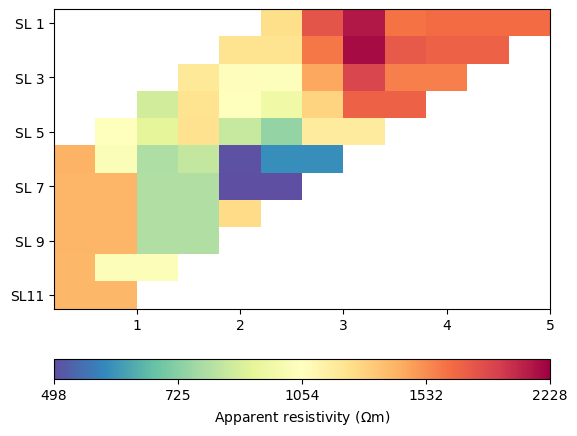

In [23]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))
print(y1)
y1.show();

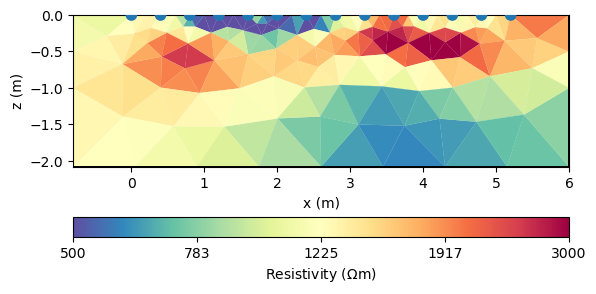

In [24]:
mgr = ert.Manager(y1)
mgr.invert(zWeight=0.3)
ax, cb = mgr.showResult(**kw)

## Mesh generation and regularization
We now want to improve the mesh a bit, step by step, introducing
a smaller boundary, a smaller surface discretization `paraDX`, a
smaller depth, an improved quality and a maximum cell size.

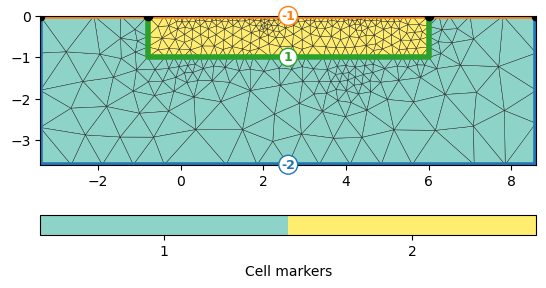

In [25]:
plc = mt.createParaMeshPLC(y1, paraDX=0.2, paraDepth=1., 
                           boundary=0.5, paraMaxCellSize=0.05) #paraDX=fraction of electrode spacing
mesh = mt.createMesh(plc, quality=34.4, smooth=True)
ax, cb = pg.show(mesh, markers=True, showMesh=True)

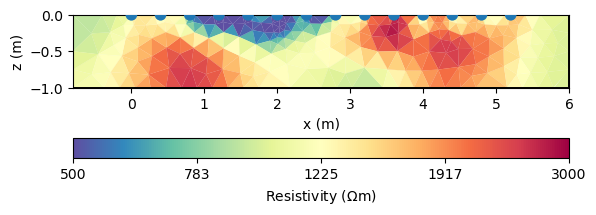

In [26]:
mgr.setMesh(mesh)
mgr.invert()
ax, cb = mgr.showResult(**kw)

The default regularization scheme are smoothness constraints of first-order, i.e. a derivative across the model cells. We can also apply second order constraints by setting this inversion property.



0.6964764743477851


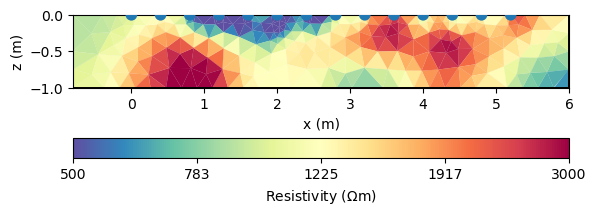

In [27]:
mgr.inv.setRegularization(cType=2) #2nd order smoothness constraint
mgr.invert()
print(mgr.inv.chi2())
ax, cb = mgr.showResult(**kw)

Alternative to classical smoothness constraints, geostatistical operators can be used for regularization. For details on the method see the paper of Jordi et al. (2018) and [the corresponding tutorial](https://www.pygimli.org/_tutorials_auto/3_inversion/plot_6-geostatConstraints.html).

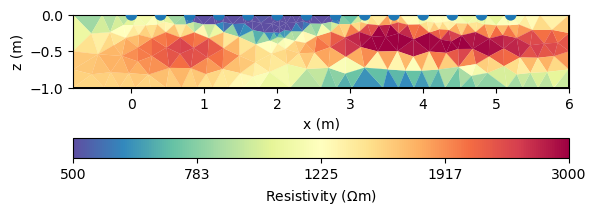

In [28]:
mgr.inv.setRegularization(correlationLengths=[1, 0.2])
mgr.invert()
ax, cb = mgr.showResult(**kw)

For a more extensive comparison of regularization methods, see [this tutorial](https://www.pygimli.org/_tutorials_auto/3_inversion/plot_5_Regularization.html).

## Additional information
### Structural constraints
Imagine we have knowledge on a geological interface, e.g. from seismic or GPR reflections. To include this structural information into the inversion, we create a line with a marker>0 and re-create the mesh. 

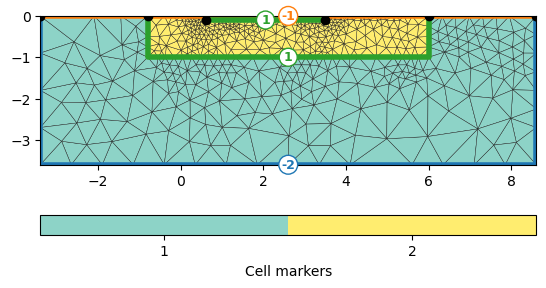

In [31]:
line = mt.createLine(start=[0.6, -0.1], 
                     end=[3.5, -0.1], marker=1)
mesh = mt.createMesh(plc+line, quality=34.4)
ax, cb = pg.show(mesh, markers=True, showMesh=True)

The interface is built into the mesh and deactivates smoothness constraints across it in inversion. For a more rigorous example see
https://www.pygimli.org/_examples_auto/6_inversion/plot_4_structural_constraints.html

We create a new manager, set the created mesh and run inversion.

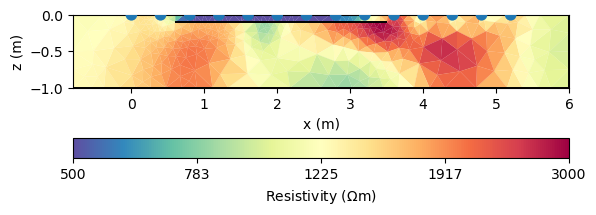

In [32]:
mgr = ert.Manager(y1)
mgr.setMesh(mesh)
mgr.invert()
ax, cb = mgr.showResult(**kw)

As a result, there is a sharp contrast in the area of the infiltration, whereas outside the effect of the constraint is lower. 

### Region-specific inversion
The regularization does not have to be the same for the whole modelling domain. We create a cube under the infiltration area for which we use different settings.

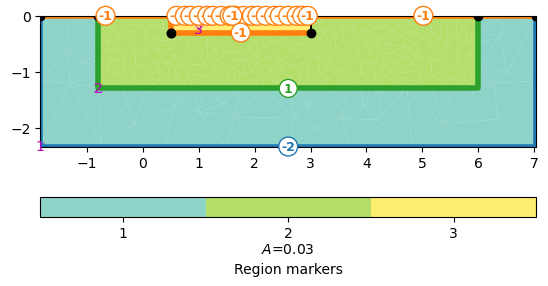

In [33]:
plc = mt.createParaMeshPLC(y1, paraDX=0.25, paraDepth=1.3, 
                           boundary=0.2, paraMaxCellSize=0.03)
cube = mt.createRectangle(start=[0.5, -0.3], end=[3, 0], 
                          marker=3, boundaryMarker=-1)
pg.show(plc+cube, markers=True);

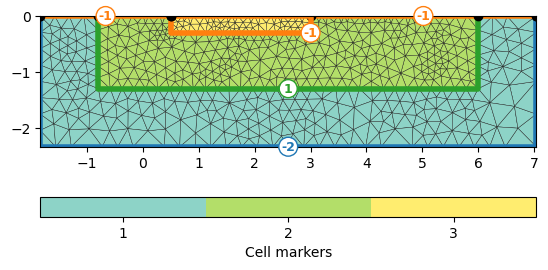

In [34]:
mesh = mt.createMesh(plc+cube, quality=34.4, smooth=True)
pg.show(mesh, markers=True, showMesh=True);
mgr.setMesh(mesh)

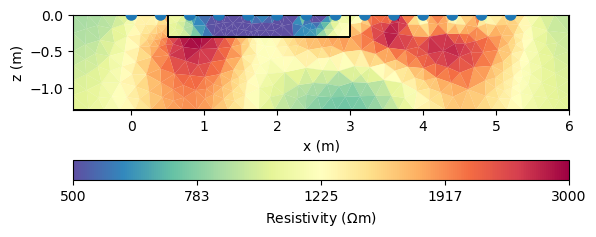

In [35]:
mgr.invert()
mgr.showResult(**kw);

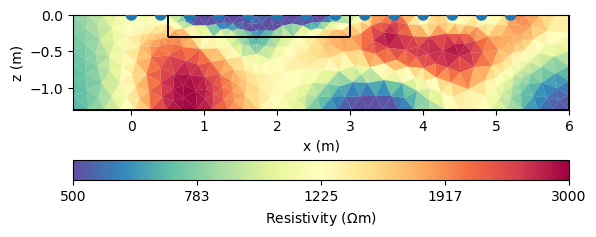

In [36]:
mgr = ert.Manager(y1)
mgr.setMesh(mesh)
mgr.inv.setRegularization(1, background=True)
mgr.inv.setRegularization(2, cType=2)
mgr.inv.setRegularization(3, cType=1, zWeight=0.3) #vertical smoothing 0.3*global smoothing
mgr.fop.regionManager().setInterRegionConstraint(2, 3, 1) #constraint between 2 & 3 not uncoupled
mgr.invert()
mgr.showModel(**kw)
# Store the model
y1result = mgr.paraDomain
y1result["res"] = mgr.model

For a more thorough overview on the region options see [this tutorial](https://www.pygimli.org/_tutorials_auto/3_inversion/plot_8-regionWise.html).

### Incorporation of petrophysics

Already in pyGIMLi 1.0 (Rücker et al., 2017), we demonstrated the incorporation of petrophysical relations in the inverse problem. In our case, we are interested in the water saturation that is described by Archie's law. To this end, there is an already defined transformation function [`transFwdArchieS`](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.petro.html#pygimli.physics.petro.transFwdArchieS). We import the function and transfer the modelled resistivity into saturation.
For the Archie equation, we use values derived by Hübner et al. (2015).

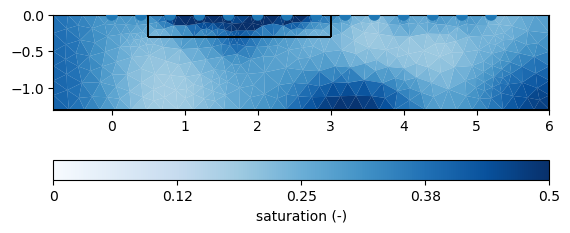

In [37]:
from pygimli.physics.petro import transFwdArchieS
tS = transFwdArchieS(rFluid=66*(1-0.02*20), 
                     phi=0.4, m=1.3, n=1.83)
satKW = dict(cMin=0, cMax=0.5, logScale=0, cMap="Blues",
             label="saturation (-)", coverage=1)
mgr.showResult(tS.inv(mgr.model), **satKW);

Next, we combine it with the ERT forward operator using the `PetroModelling` framework.

In [39]:
mgr = ert.Manager(y1, verbose=False)
mesh = mt.createMesh(plc, quality=34.4, smooth=True)
mgr.setMesh(mesh)
fop = pg.frameworks.PetroModelling(mgr.fop, tS)

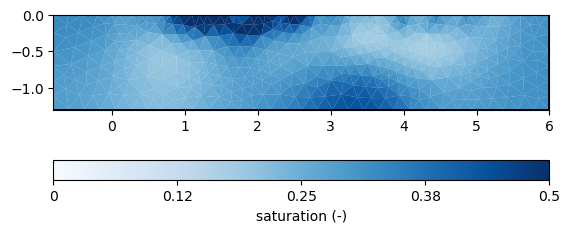

In [40]:
fop.setMesh(mesh)
inv = pg.Inversion(fop=fop)
# inv.setRegularization(1, background=True)
# inv.setRegularization(2, limits=[0, 1], zWeight=0.3)
model = inv.run(y1["rhoa"], relativeError=y1["err"], 
                startModel=0.2)
pg.show(mgr.paraDomain, model, **satKW);

### Parameter constraints
Besides from structural information, one may have parameter information, e.g. from a borehole or direct-push sounding. For an example, see
https://www.pygimli.org/_examples_auto/6_inversion/plot_5_ert_with_priors.html

We define each four equidistant points in 10 cm depth and in 50 cm depth and assume a saturation of 0.5 for the upper ones and the lower ones.

In [41]:
xpos = [1, 1.5, 2, 2.5]
pos = np.array([[x, -0.1] for x in xpos] + 
               [[x, -0.5] for x in xpos])
pointSat = pg.cat(np.ones_like(xpos) * 0.5, 
                  np.ones_like(xpos) * 0.2)

We generate a prior modelling operator that indexes into a given mesh, here the inversion domain.

In [42]:
invmesh = mgr.paraDomain
invmesh["marker"] = 0
pointFop = pg.frameworks.PriorModelling(invmesh, pos)

Now we combine the ERT forward operator and the prior mapping operator by the `JointModelling` framework.
We set the individual data for the two operators and run a (joint) inversion for the new modelling operator.

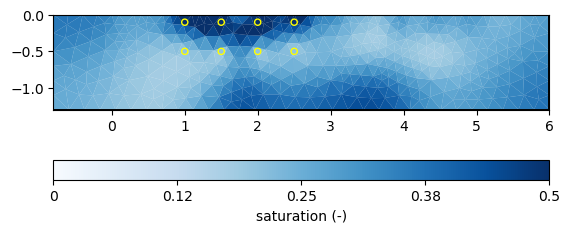

In [43]:
fopJoint = pg.frameworks.JointModelling([fop, pointFop])
fopJoint.setData([y1, pointSat])
invJoint = pg.Inversion(fopJoint)
invJoint.setRegularization(limits=[0, 1])
dataVec = pg.cat(y1["rhoa"], pointSat)
errorVec = pg.cat(y1["err"], 0.03/pointSat)
invJoint.setRegularization(cType=2) #correlationLengths=[1, .2])
modelJoint = invJoint.run(dataVec, relatativeError=errorVec, 
                          lam=300, startModel=0.2)
ax, cb = pg.show(invmesh, modelJoint, **satKW)
ax.scatter(pos[:, 0], pos[:, 1], c=pointSat, s=20, 
           vmin=satKW["cMin"], vmax=satKW["cMax"], 
           cmap=satKW["cMap"], ec="yellow");

## 3D visualization
Now we bring the 2D result of the y-directed profile  into 3D by changing the dimension, switching y (in 2D depth axis) and z coordinates and shifting the mesh into the correct y position.

In [34]:
y1result.setDimension(3)
y1result.swapCoordinates(1, 2) # make 2D depth to 3D depth
y1result.translate([0, 0.6, 0])

Mesh: Nodes: 381 Cells: 668 Boundaries: 113
Mesh contains data: res

Similarly, we do so for the y-directed profile x0, for which we additionally have to exchange the x with the y coordinate

In [35]:
x0result.setDimension(3)
x0result.swapCoordinates(1, 2) # 2D depth to 3D
x0result.swapCoordinates(0, 1) # 2D x to 3D y

In [36]:
kw.pop('coverage')
kw.pop('xlabel')
kw.pop('ylabel')
pl, _ = pg.show(x0result, "res", **kw, hold=True)
pv.drawMesh(pl, y1result, label="res", **kw, 
            colorBar=False)
pl.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x1d436a391f0_0" src="http://localhost:8888/trame-…

## 3D inversion
For a 3D inversion of all data, one needs to create a 3D mesh. To do so, first the geometry is created and then meshed (just like in 2D).

In [37]:
plc = mt.createParaMeshPLC3D(data)
mesh = mt.createMesh(plc, quality=1.3)
print(mesh)
# pg.show(mesh, style="wireframe")

Mesh: Nodes: 1762 Cells: 7984 Boundaries: 16854


In [ ]:
mgr3d = ert.Manager(data)
mgr3d.setMesh(mesh)
mgr3d.invert(verbose=True)

fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001D3AF95C400>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001D3AF95CDB0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001D3AF95C450>
min/max (data): 152/2558
min/max (error): 2%/2%
min/max (start model): 1089/1089
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  398.27
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   27.34 (dPhi = 92.44%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   13.75 (dPhi = 44.25%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.95 (dPhi = 37.67%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    5.38 (dPhi = 13.57%) lam: 20.0
-----------------

In [ ]:
result3d = mgr3d.paraDomain
result3d["res"] = mgr3d.paraModel()
pl, _ = pg.show(result3d, label="res", style="surface", hold=True, **kw,
                filter={"threshold": dict(value=400, scalars="res", method="lower")})
pv.drawMesh(pl, result3d, label="res", style="surface", **kw,
            filter={"slice": dict(normal="y", origin=[0, 1, 0])})
pl.show()

## Timelapse inversion

For this data set, we have a lot of data over a couple of days.
Of course, we could invert these step by step and compare the
individual models.
For timelapse ERT, there is a specialized class `TimelapseERT`.
It handles the data, e.g. filtering and masking, but also 
exhibits several timelapse strategies, such as 4D inversion.

For more details, see the example on [time-lapse ERT](https://www.pygimli.org/_examples_auto/3_ert/plot_09_ert_timelapse.html).

In [ ]:
DATA = []
for nr in [0, 1, 2, 4, 10, 40]:
    data = pg.getExampleData(f"ert/Huebner2017/{nr:03d}.dat")
    data2d = data.subset(y=1.4)
    data2d.setSensors(data2d.sensors() * np.array([1, 0, 0]))
    DATA.append(data2d)

tl = ert.TimelapseERT(DATA)
print(tl)

In [ ]:
tl.invert(paraDepth=1.3, correlationLengths=[1, 0.4])
tl.showAllModels(ratio=True, rMax=2, orientation="vertical");

In [ ]:
tl.fullInversion(C=tl.mgr.fop.constraints())
tl.showAllModels(ratio=True, rMax=2, orientation="vertical");

For a more rigorous explanation of time-lapse strategies see

https://www.pygimli.org/_examples_auto/3_ert/plot_09_ert_timelapse.html

In [ ]:
# tl = ert.TimelapseERT("*.dat")
# print(tl)
# tl.fullInversion()

## References
* Hübner, R., Günther, T., Heller, K., Noell, U. & Kleber, A. (2017): Impacts of a capillary barrier on infiltration and subsurface stormflow in layered slope deposits monitored with 3-D ERT and hydrometric measurements. Hydrol. Earth Syst. Sci. 21, 5181-5199, [doi:10.5194/hess-21-5181-2017](https://doi.org/10.5194/hess-21-5181-2017).
* Jordi, C., Doetsch, J., Günther, T., Schmelzbach, C. & Robertsson, J.O.A. (2018): Geostatistical regularisation operators for geophysical inverse problems on irregular meshes. Geophys. J. Int. 213, 1374-1386, [doi:10.1093/gji/ggy055](https://doi.org/10.1093/gji/ggy055).
* Grünenbaum, N., Günther, T., Greskowiak, J., Vienken, T., Müller-Petke, M. & Massmann, G. (2023): Salinity distribution in the subterranean estuary of a meso-tidal high-energy beach characterized by Electrical Resistivity Tomography and Direct Push technology. J. of Hydrol. 617, 129074, [doi:10.1016/j.jhydrol.2023.129074](https://doi.org/10.1016/j.jhydrol.2023.129074).
* Rücker, C., Günther, T., Wagner, F.M. (2017): pyGIMLi: An open-source library for modelling and inversion in geophysics, Computers & Geosciences 109, 106-123, [doi:10.1016/j.cageo.2017.07.011](https://doi.org/10.1016/j.cageo.2017.07.011).
* Hübner, R., Heller, K., Günther, T. & Kleber, A. (2015): Monitoring hillslope moisture dynamics with sur- face ERT for enhancing spatial significance of hydrometric point measurements. Hydrology and Earth System Sciences 19(1), 225-240, [doi:10.5194/hess-19-225-2015](https://doi.org/10.5194/hess-19-225-2015).
* Udphuay, S., Günther, T., Everett, M.E., Warden, R.R. & Briaud, J.-L. (2011): Three-dimensional resistivity tomography in extreme coastal terrain amidst dense cultural signals: application to cliff stability assessment at the historic D-Day site. Geophys. J. Int. 185(1), 201-220, [doi:10.1111/j.1365-246X.2010.04915.x](https://doi.org/10.1111/j.1365-246X.2010.04915.x).


